In [ ]:
!pip install pytrends

In [2]:
from datetime import datetime, timedelta
from pytrends.request import TrendReq
import pandas as pd
import os
import sys
import time

In [ ]:
## INITIAL COMMENTS ##
# Re-scale Trends data so that all values are on the same scale.

# Why do we do this?
# To obtain data at the a certain resolution from Google Trends,
# it must be requested in batches (for example, 1-hour data
# needs to be requested in 7-day intervals).
# However, the values that the Trends API returns are scaled
# from 0-100 within that batch, so it is impossible to compare
# data points from different batches.
# This script re-scales the data by requesting batches with
# overlapping time periods.


## SETUP ##
path = '.'
os.chdir(path)
filename = 'google_trends_BTC_index_overlapped.csv'

# The maximum for a timeframe for which we get daily data is 270.
# Therefore we could go back 269 days. However, since there might
# be issues when rescaling, e.g. zero entries, we should have an
# overlap that does not consist of only one period. Therefore,
# I limit the step size to 250. This leaves 19 periods for overlap.
maxstep=269
overlap=40
step    = maxstep - overlap + 1
dt = timedelta(days=step)
time_fmt = '%Y-%m-%d'

kw_list = ['bitcoin']
start_date = datetime(2013, 1, 1).date()


## FIRST RUN ##

# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()

# Run the first time (if we want to start from today, otherwise we need to ask for an end_date as well
#today = datetime(2019, 3, 1).date() 
today = datetime.today().date()
old_date = today

# Go back in time
new_date = today - dt #timedelta(hours=step)

# Create new timeframe for which we download data
timeframe = new_date.strftime(time_fmt)+' '+old_date.strftime(time_fmt)
print(timeframe)
pytrend.build_payload(kw_list=kw_list, timeframe = timeframe)
interest_over_time_df = pytrend.interest_over_time()

## RUN ITERATIONS
# Note this runs backwards from the most recent date back.
while new_date>start_date:
    
    ### Save the new date from the previous iteration.
    # Overlap == 1 would mean that we start where we
    # stopped on the iteration before, which gives us
    # indeed overlap == 1.
    old_date = new_date + timedelta(hours=overlap-1)
    
    ### Update the new date to take a step into the past
    # Since the timeframe that we can apply for daily data
    # is limited, we use step = maxstep - overlap instead of
    # maxstep.
    new_date = new_date - dt #timedelta(hours=step)
    # If we went past our start_date, use it instead
    if new_date < start_date:
        new_date = start_date
        
    # New timeframe
    timeframe = new_date.strftime(time_fmt)+' '+old_date.strftime(time_fmt)
    print(timeframe)

    # Download data
    pytrend.build_payload(kw_list=kw_list, timeframe = timeframe, geo='')
    temp_df = pytrend.interest_over_time()
    if (temp_df.empty):
        raise ValueError('Google sent back an empty dataframe. Possibly there were no searches at all during the this period! Set start_date to a later date.')
    # Renormalize the dataset and drop last line
    for kw in kw_list:
        beg = new_date
        end = old_date - timedelta(hours=1)
        
        # Since we might encounter zeros, we loop over the
        # overlap until we find a non-zero element
        for t in range(1,overlap+1):
            #print('t = ',t)
            #print(temp_df[kw].iloc[-t])
            if temp_df[kw].iloc[-t] != 0:
                # TODO dame da kore...
                
                scaling = float(interest_over_time_df[kw].iloc[t-1])/temp_df[kw].iloc[-t]
                #print('Found non-zero overlap!')
                print(scaling)
                break
            elif t == overlap:
                print('Did not find non-zero overlap, set scaling to zero! Increase Overlap!')
                scaling = 0
        # Apply scaling
        temp_df.loc[beg:end,kw]=temp_df.loc[beg:end,kw]*scaling
    interest_over_time_df = pd.concat([temp_df[:-overlap],interest_over_time_df])
    time.sleep(1)

# Save dataset
interest_over_time_df.to_csv(filename)
btc_google_trends1 = interest_over_time_df

In [4]:
from datetime import date, timedelta
from functools import partial
from time import sleep
from calendar import monthrange

import pandas as pd

from pytrends.exceptions import ResponseError
from pytrends.request import TrendReq

In [5]:
#pyTrends getDaily function
filename = 'google_trends_BTC_index_fromPyTrends.csv'

def get_last_date_of_month(year: int, month: int) -> date:
    """Given a year and a month returns an instance of the date class
    containing the last day of the corresponding month.
    Source: https://stackoverflow.com/questions/42950/get-last-day-of-the-month-in-python
    """
    return date(year, month, monthrange(year, month)[1])


def convert_dates_to_timeframe(start: date, stop: date) -> str:
    """Given two dates, returns a stringified version of the interval between
    the two dates which is used to retrieve data for a specific time frame
    from Google Trends.
    """
    return f"{start.strftime('%Y-%m-%d')} {stop.strftime('%Y-%m-%d')}"


def _fetch_data(pytrends, build_payload, timeframe: str) -> pd.DataFrame:
    """Attempts to fecth data and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            build_payload(timeframe=timeframe)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return pytrends.interest_over_time()


def get_daily_data(word: str,
                 start_year: int,
                 start_mon: int,
                 stop_year: int,
                 stop_mon: int,
                 geo: str = 'US',
                 verbose: bool = True,
                 wait_time: float = 5.0) -> pd.DataFrame:
    """Given a word, fetches daily search volume data from Google Trends and
    returns results in a pandas DataFrame.
    Details: Due to the way Google Trends scales and returns data, special
    care needs to be taken to make the daily data comparable over different
    months. To do that, we download daily data on a month by month basis,
    and also monthly data. The monthly data is downloaded in one go, so that
    the monthly values are comparable amongst themselves and can be used to
    scale the daily data. The daily data is scaled by multiplying the daily
    value by the monthly search volume divided by 100.
    For a more detailed explanation see http://bit.ly/trendsscaling
    Args:
        word (str): Word to fetch daily data for.
        start_year (int): the start year
        start_mon (int): start 1st day of the month
        stop_year (int): the end year
        stop_mon (int): end at the last day of the month
        geo (str): geolocation
        verbose (bool): If True, then prints the word and current time frame
            we are fecthing the data for.
    Returns:
        complete (pd.DataFrame): Contains 4 columns.
            The column named after the word argument contains the daily search
            volume already scaled and comparable through time.
            The column f'{word}_unscaled' is the original daily data fetched
            month by month, and it is not comparable across different months
            (but is comparable within a month).
            The column f'{word}_monthly' contains the original monthly data
            fetched at once. The values in this column have been backfilled
            so that there are no NaN present.
            The column 'scale' contains the scale used to obtain the scaled
            daily data.
    """

    # Set up start and stop dates
    start_date = date(start_year, start_mon, 1) 
    stop_date = get_last_date_of_month(stop_year, stop_mon)

    # Start pytrends for US region
    pytrends = TrendReq(hl='', tz=360)
    # Initialize build_payload with the word we need data for
    build_payload = partial(pytrends.build_payload, kw_list=[word], cat=0, geo=geo, gprop='')

    # Obtain monthly data for all months in years [start_year, stop_year]
    monthly = _fetch_data(pytrends, build_payload, convert_dates_to_timeframe(start_date, stop_date))

    # Get daily data, month by month
    results = {}
    # if a timeout or too many requests error occur we need to adjust wait time
    current = start_date
    while current < stop_date:
        last_date_of_month = get_last_date_of_month(current.year, current.month)
        timeframe = convert_dates_to_timeframe(current, last_date_of_month)
        if verbose:
            print(f'{word}:{timeframe}')
        results[current] = _fetch_data(pytrends, build_payload, timeframe)
        current = last_date_of_month + timedelta(days=1)
        sleep(wait_time)  # don't go too fast or Google will send 429s

    daily = pd.concat(results.values()).drop(columns=['isPartial'])
    complete = daily.join(monthly, lsuffix='_unscaled', rsuffix='_monthly')

    # Scale daily data by monthly weights so the data is comparable
    complete[f'{word}_monthly'].ffill(inplace=True)  # fill NaN values
    complete['scale'] = complete[f'{word}_monthly'] / 100
    complete[word] = complete[f'{word}_unscaled'] * complete.scale

    return complete

In [ ]:
btc_google_trends2 = get_daily_data(word="bitcoin", start_year=2013, start_mon=1, stop_year=2021, stop_mon=6, verbose=True, wait_time=1, geo='')
btc_google_trends2.to_csv(filename)

In [7]:
from datetime import datetime, timedelta, date, time
import pandas as pd
import time

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

filename = 'google_trends_BTC_index_from_gtrend.csv'

def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

In [8]:
btc_google_trends3 = get_daily_trend(TrendReq(hl='', tz=360), "bitcoin", "2013-01-01", "2021-06-17", geo='' )
btc_google_trends3.to_csv(filename) 

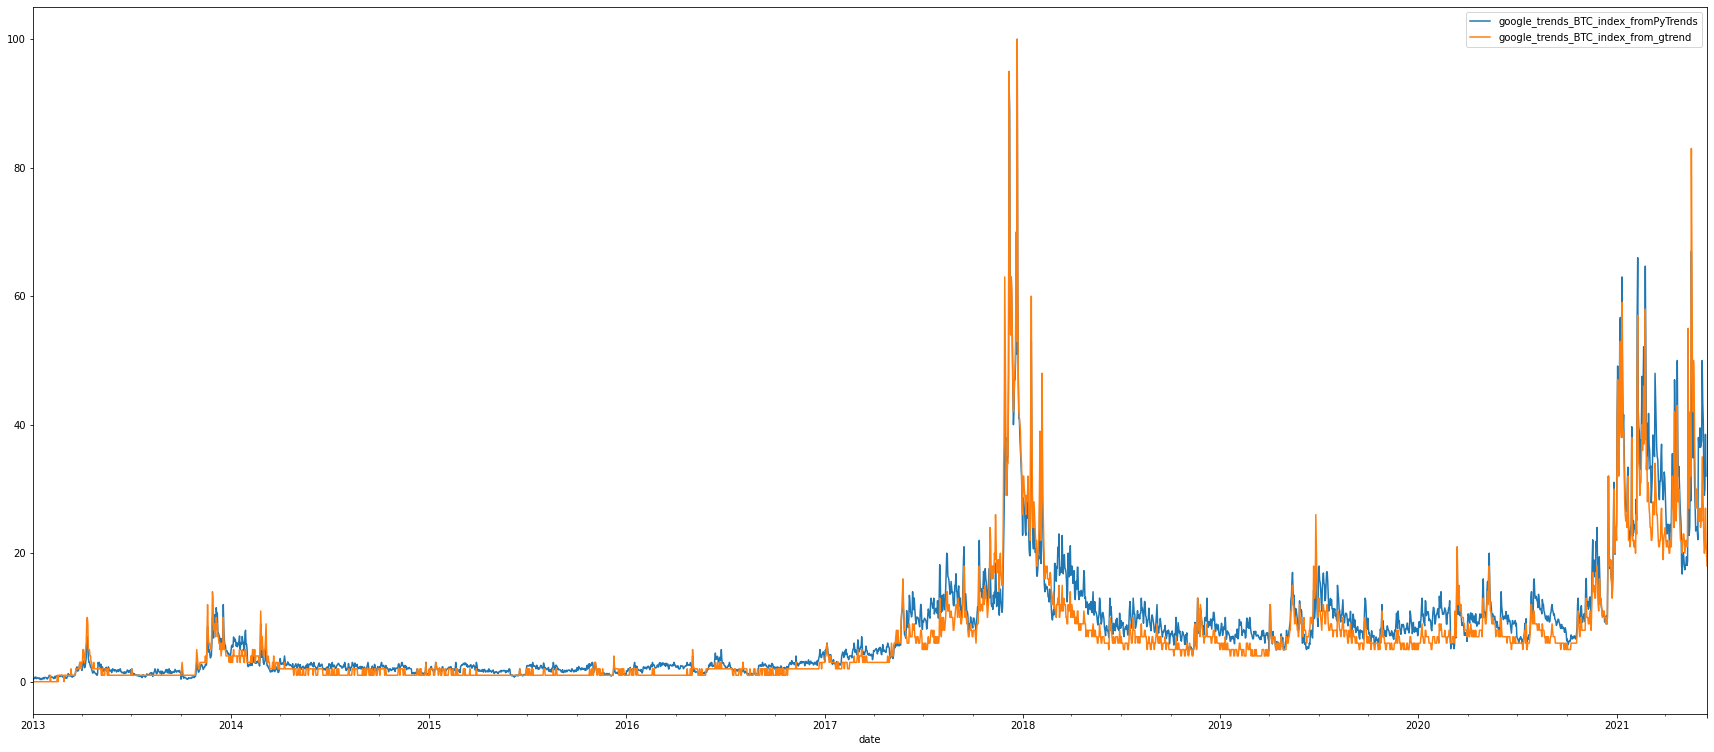

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 13))

btc_google_trends1["bitcoin"].plot(label="google_trends_BTC_index_overlapped")
btc_google_trends2["bitcoin"].plot(label="google_trends_BTC_index_fromPyTrends")
btc_google_trends3["bitcoin"].plot(label="google_trends_BTC_index_from_gtrend")
plt.legend()